#Supervised Contrastive Learning

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Implementation by G. M. Shahariar Shibli

#Version and GPU check

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#Installation

In [ ]:
%%capture
!pip3 install tensorflow-addons
!pip3 install tf_keras_vis

#Imports

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow import keras

import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import numpy as np
import cv2
import datetime
import glob
import os

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

#Configurations

In [ ]:
BATCH_SIZE = 64
EPOCHS = 50
CROP_TO = 224

num_classes = 23
input_shape = (224, 224, 3)

LR = 2e-5
shuffler = 1024

#Data Augmentation

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image, label):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image, label

# Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print('Test set cecum' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/cecum')))
print('Test set barretts' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/barretts')))
print('Test set barretts-short-segment' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/barretts-short-segment')))
print('Test set bbps-0-1' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/bbps-0-1')))
print('Test set bbps-2-3' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/bbps-2-3')))
print('Test set dyed-lifted-polyps' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/dyed-lifted-polyps')))
print('Test set dyed-resection-margins' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/dyed-resection-margins')))
print('Test set esophagitis-a' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-a')))
print('Test set esophagitis-b-d' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-b-d')))
print('Test set hemorrhoids' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/hemorrhoids')))
print('Test set ileum' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/ileum')))
print('Test set impacted-stool' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/impacted-stool')))
print('Test set ulcerative-colitis-grade-0-1' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-0-1')))
print('Test set ulcerative-colitis-grade-1' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1')))
print('Test set ulcerative-colitis-grade-1-2' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1-2')))
print('Test set ulcerative-colitis-grade-2' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2')))
print('Test set ulcerative-colitis-grade-2-3' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2-3')))
print('Test set ulcerative-colitis-grade-3' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-3')))
print('Test set polyps' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/polyps')))
print('Test set pylorus' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/pylorus')))
print('Train set retroflex_rectum' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/retroflex_rectum')))
print('Train set retroflex_stomach' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/retroflex_stomach')))
print('Train set z_line' , len(os.listdir('/content/drive/MyDrive/ML/Classification/LOw/z_line')))

Test set cecum 1009
Test set barretts 41
Test set barretts-short-segment 53
Test set bbps-0-1 646
Test set bbps-2-3 1148
Test set dyed-lifted-polyps 1002
Test set dyed-resection-margins 989
Test set esophagitis-a 403
Test set esophagitis-b-d 260
Test set hemorrhoids 6
Test set ileum 9
Test set impacted-stool 131
Test set ulcerative-colitis-grade-0-1 35
Test set ulcerative-colitis-grade-1 201
Test set ulcerative-colitis-grade-1-2 11
Test set ulcerative-colitis-grade-2 443
Test set ulcerative-colitis-grade-2-3 28
Test set ulcerative-colitis-grade-3 133
Test set polyps 1028
Test set pylorus 999
Train set retroflex_rectum 391
Train set retroflex_stomach 764
Train set z_line 932


In [ ]:
cecum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/cecum/*.*')
ileum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ileum/*.*')
retroflex_rectum = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_rectum/*.*')
hemorrhoids = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/hemorrhoids/*.*')
polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/polyps/*.*')
ulcerative_colitis_grade_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-0-1/*.*')
ulcerative_colitis_grade_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1/*.*')
ulcerative_colitis_grade_1_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-1-2/*.*')
ulcerative_colitis_grade_2 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2/*.*')
ulcerative_colitis_grade_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-2-3/*.*')
ulcerative_colitis_grade_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/ulcerative-colitis-grade-3/*.*')
bbps_0_1 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-0-1/*.*')
bbps_2_3 = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/bbps-2-3/*.*')
impacted_stool = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/impacted-stool/*.*')
dyed_lifted_polyps = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-lifted-polyps/*.*')
dyed_resection_margins = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/dyed-resection-margins/*.*')
pylorus = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/pylorus/*.*')
retroflex_stomach = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/retroflex_stomach/*.*')
z_line = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/z_line/*.*')
barretts = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts/*.*')
barretts_short_segment = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/barretts-short-segment/*.*')
esophagitis_a = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-a/*.*')
esophagitis_b_d = glob.glob('/content/drive/MyDrive/ML/Classification/LOw/esophagitis-b-d/*.*')

In [ ]:
dataset = {0 :cecum, 1:ileum, 2:retroflex_rectum, 3:hemorrhoids, 4:polyps,5:ulcerative_colitis_grade_0_1,6:ulcerative_colitis_grade_1,7:ulcerative_colitis_grade_1_2,8:ulcerative_colitis_grade_2,9:ulcerative_colitis_grade_2_3,10:ulcerative_colitis_grade_3,11:bbps_0_1 ,12:bbps_2_3,13:impacted_stool,14:dyed_lifted_polyps,15:dyed_resection_margins,16:pylorus,17:retroflex_stomach,18:z_line,19:barretts,20:barretts_short_segment,21:esophagitis_a ,22:esophagitis_b_d }

In [ ]:
def combineDataAndLabel(width, height, dataset):

  data = []
  labels = []
  count = 0

  for cls in dataset:
      print(f"\n\nconverting {cls} \n\n")
      for i in dataset[cls]:
          print(f"\nconverting image:  {i}")
          image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
          target_size= (width,height))
          image=np.array(image)
          data.append(image)
          count=count+1
          labels.append(cls)
      print(f"\n\processed {count} images \n\n")


  # for i in cecum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(0)

  # for i in ileum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(1)
  # for i in pylorus:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(2)
  # for i in retroflex_rectum:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(3)
  # for i in retroflex_stomach:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(4)
  # for i in z_line:
  #     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
  #     target_size= (width,height))
  #     image=np.array(image)
  #     data.append(image)
  #     labels.append(5)

  data = np.array(data)
  labels = np.array(labels)

  print(f"\n\nSaving to drive\n\n")
  np.save('/content/drive/MyDrive/ML/combinedData_224', data)
  np.save('/content/drive/MyDrive/ML/combinedLabels_224', labels)
  print(f"\n\nSaved")

  return data, labels


In [ ]:
import os
data = []
labels = []
if(os.path.isfile("/content/drive/MyDrive/ML/combinedData_224.npy") and os.path.isfile("/content/drive/MyDrive/ML/combinedLabels_224.npy")):
  data = np.load("/content/drive/MyDrive/ML/combinedData_224.npy")
  labels = np.load("/content/drive/MyDrive/ML/combinedLabels_224.npy")
else:
  data, labels = combineDataAndLabel(224,224,dataset)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42,stratify = labels)

In [ ]:
# Load data
#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (8529, 224, 224, 3) - y_train shape: (8529,)
x_test shape: (2133, 224, 224, 3) - y_test shape: (2133,)


In [ ]:
#contrastive training
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (train_ds.shuffle(shuffler).map(custom_augment).batch(BATCH_SIZE))

#cross-entropy training
train_ds2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(shuffler).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(shuffler).batch(BATCH_SIZE)

#Contrastive Loss Functions

Max Margin Loss, N pairs loss, Triplet loss, NT-XENT loss

In [ ]:
def pdist_euclidean(A):
    # Euclidean pdist
    # https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
    r = tf.reduce_sum(A*A, 1)

    # turn r into column vector
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return tf.sqrt(D)


#def square_to_vec(D):
   #'''Convert a squared form pdist matrix to vector form.
    #'''
 #   n = D.shape[0]
  #  triu_idx = np.triu_indices(n, k=1)
   # d_vec = tf.gather_nd(D, list(zip(triu_idx[0], triu_idx[1])))
    #return d_vec
def square_to_vec(D):
    with tf.name_scope("square_to_vec"):
        n = D.shape[0]
        triu_idx = np.triu_indices(n, k=1)
        triu_idx_int = np.array(triu_idx).astype(np.int32)
        d_vec = tf.gather_nd(D, list(zip(triu_idx_int[0], triu_idx_int[1])))
        return d_vec


def get_contrast_batch_labels(y):
    '''
    Make contrast labels by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    y_col_vec = tf.reshape(tf.cast(y, tf.float32), [-1, 1])
    D_y = pdist_euclidean(y_col_vec)
    d_y = square_to_vec(D_y)
    y_contrasts = tf.cast(d_y == 0, tf.int32)
    return y_contrasts


def get_contrast_batch_labels_regression(y):
    '''
    Make contrast labels for regression by taking all the pairwise in y
    y: tensor with shape: (batch_size, )
    returns:
        tensor with shape: (batch_size * (batch_size-1) // 2, )
    '''
    raise NotImplementedError


def max_margin_contrastive_loss(z, y, margin=1.0, metric='euclidean'):
    '''
    Wrapper for the maximum margin contrastive loss (Hadsell et al. 2006)
    `tfa.losses.contrastive_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
        metric: one of ('euclidean', 'cosine')
    '''
    # compute pair-wise distance matrix
    if metric == 'euclidean':
        D = pdist_euclidean(z)
    elif metric == 'cosine':
        D = 1 - tf.matmul(z, z, transpose_a=False, transpose_b=True)
    # convert squareform matrix to vector form
    d_vec = square_to_vec(D)
    # make contrastive labels
    y_contrasts = get_contrast_batch_labels(y)
    loss = tfa.losses.contrastive_loss(y_contrasts, d_vec, margin=margin)
    # exploding/varnishing gradients on large batch?
    return tf.reduce_mean(loss)


def multiclass_npairs_loss(z, y):
    '''
    Wrapper for the multiclass N-pair loss (Sohn 2016)
    `tfa.losses.npairs_loss`
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    # cosine similarity matrix
    S = tf.matmul(z, z, transpose_a=False, transpose_b=True)
    loss = tfa.losses.npairs_loss(y, S)
    return loss


def triplet_loss(z, y, margin=1.0, kind='hard'):
    '''
    Wrapper for the triplet losses
    `tfa.losses.triplet_hard_loss` and `tfa.losses.triplet_semihard_loss`
    Args:
        z: hidden vector of shape [bsz, n_features], assumes it is l2-normalized.
        y: ground truth of shape [bsz].
    '''
    if kind == 'hard':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=False)
    elif kind == 'soft':
        loss = tfa.losses.triplet_hard_loss(y, z, margin=margin, soft=True)
    elif kind == 'semihard':
        loss = tfa.losses.triplet_semihard_loss(y, z, margin=margin)
    return loss


def supervised_nt_xent_loss(z, y, temperature=0.5, base_temperature=0.07):
    '''
    Supervised normalized temperature-scaled cross entropy loss.
    A variant of Multi-class N-pair Loss from (Sohn 2016)
    Later used in SimCLR (Chen et al. 2020, Khosla et al. 2020).
    Implementation modified from:
        - https://github.com/google-research/simclr/blob/master/objective.py
        - https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Args:
        z: hidden vector of shape [bsz, n_features].
        y: ground truth of shape [bsz].
    '''
    batch_size = tf.shape(z)[0]
    contrast_count = 1
    anchor_count = contrast_count
    y = tf.expand_dims(y, -1)

    # mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
    #     has the same class as sample i. Can be asymmetric.
    mask = tf.cast(tf.equal(y, tf.transpose(y)), tf.float32)
    anchor_dot_contrast = tf.divide(
        tf.matmul(z, tf.transpose(z)),
        temperature
    )
    # # for numerical stability
    logits_max = tf.reduce_max(anchor_dot_contrast, axis=1, keepdims=True)
    logits = anchor_dot_contrast - logits_max
    # # tile mask
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    # compute log_prob
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - \
        tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # compute mean of log-likelihood over positive
    # this may introduce NaNs due to zero division,
    # when a class only has one example in the batch
    mask_sum = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(
        mask * log_prob, axis=1)[mask_sum > 0] / mask_sum[mask_sum > 0]

    # loss
    loss = -(temperature / base_temperature) * mean_log_prob_pos
    # loss = tf.reduce_mean(tf.reshape(loss, [anchor_count, batch_size]))
    loss = tf.reduce_mean(loss)
    return loss

#Encoder with Contrastive Learning

In [ ]:
#Layer Batch Normalization
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''

    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [ ]:
# Encoder Architecture
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True
    h = base_model.output
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    normalized_embed = UnitNormLayer()(projection_3)

    resnet_simclr = Model(base_model.inputs, normalized_embed)

    return resnet_simclr

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model = get_resnet_simclr(512, 256, 128)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
train_loss_cl = tf.keras.metrics.Mean(name='train_loss')
test_loss_cl = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
@tf.function

def train_step_contrastive(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        r = model(x, training=True)
        loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')

    gradients = tape.gradient(loss, model.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss_cl(loss)

In [ ]:
@tf.function
def test_step_contrastive(x, y):
    r = model(x, training=False)
    t_loss = max_margin_contrastive_loss(r, y, margin=1.0, metric='euclidean')
    test_loss_cl(t_loss)

In [ ]:
#Encoder training
train_loss_dict = {}
test_loss_dict = {}

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss_cl.reset_states()
    test_loss_cl.reset_states()

    for x, y in tqdm(train_ds):
        train_step_contrastive(x, y)

    for x_te, y_te in test_ds:
        test_step_contrastive(x_te, y_te)

    template = 'Epoch {}, Training Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,train_loss_cl.result(),test_loss_cl.result()))
    train_loss_dict[epoch] = train_loss_cl.result().numpy()*100
    test_loss_dict[epoch] = test_loss_cl.result().numpy()*100

100%|██████████| 134/134 [02:19<00:00,  1.04s/it]


Epoch 1, Training Loss: 0.09745275974273682, Test Loss: 0.619347095489502


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 2, Training Loss: 0.06745393574237823, Test Loss: 0.2975299060344696


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]


Epoch 3, Training Loss: 0.06515383720397949, Test Loss: 0.06355302780866623


100%|██████████| 134/134 [01:22<00:00,  1.63it/s]


Epoch 4, Training Loss: 0.06280467659235, Test Loss: 0.05725561082363129


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 5, Training Loss: 0.06168721988797188, Test Loss: 0.054977886378765106


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 6, Training Loss: 0.059881195425987244, Test Loss: 0.05671875178813934


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 7, Training Loss: 0.05861416459083557, Test Loss: 0.05376804992556572


100%|██████████| 134/134 [02:21<00:00,  1.06s/it]


Epoch 8, Training Loss: 0.05707431584596634, Test Loss: 0.052538417279720306


100%|██████████| 134/134 [01:23<00:00,  1.61it/s]


Epoch 9, Training Loss: 0.0574638694524765, Test Loss: 0.05085435509681702


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 10, Training Loss: 0.05500870943069458, Test Loss: 0.04815481975674629


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 11, Training Loss: 0.05493595078587532, Test Loss: 0.04701664671301842


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 12, Training Loss: 0.05365755036473274, Test Loss: 0.046064164489507675


100%|██████████| 134/134 [01:22<00:00,  1.63it/s]


Epoch 13, Training Loss: 0.050561707466840744, Test Loss: 0.04814673960208893


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 14, Training Loss: 0.05029185116291046, Test Loss: 0.04056333005428314


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 15, Training Loss: 0.04970011115074158, Test Loss: 0.04010425880551338


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 16, Training Loss: 0.04870198667049408, Test Loss: 0.03959612548351288


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 17, Training Loss: 0.04685600847005844, Test Loss: 0.04164137691259384


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 18, Training Loss: 0.04613311588764191, Test Loss: 0.03637842461466789


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 19, Training Loss: 0.04548855498433113, Test Loss: 0.03774124011397362


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 20, Training Loss: 0.04364994913339615, Test Loss: 0.03461959958076477


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 21, Training Loss: 0.04310895875096321, Test Loss: 0.0338197685778141


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 22, Training Loss: 0.04242841526865959, Test Loss: 0.03708170726895332


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 23, Training Loss: 0.0419841893017292, Test Loss: 0.033692725002765656


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 24, Training Loss: 0.04120739549398422, Test Loss: 0.03506249561905861


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 25, Training Loss: 0.040341224521398544, Test Loss: 0.03372044116258621


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 26, Training Loss: 0.03957946226000786, Test Loss: 0.03260957822203636


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 27, Training Loss: 0.039066195487976074, Test Loss: 0.03127098083496094


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 28, Training Loss: 0.03851798176765442, Test Loss: 0.03111872635781765


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 29, Training Loss: 0.03773265704512596, Test Loss: 0.029529718682169914


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 30, Training Loss: 0.038113102316856384, Test Loss: 0.033153217285871506


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 31, Training Loss: 0.03717799857258797, Test Loss: 0.028696291148662567


100%|██████████| 134/134 [01:22<00:00,  1.63it/s]


Epoch 32, Training Loss: 0.036348648369312286, Test Loss: 0.03009486198425293


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 33, Training Loss: 0.036179281771183014, Test Loss: 0.029753608629107475


100%|██████████| 134/134 [01:22<00:00,  1.63it/s]


Epoch 34, Training Loss: 0.034359999001026154, Test Loss: 0.03125549107789993


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 35, Training Loss: 0.0345434807240963, Test Loss: 0.02791384421288967


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 36, Training Loss: 0.03431065008044243, Test Loss: 0.030268056318163872


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 37, Training Loss: 0.03401092439889908, Test Loss: 0.027947094291448593


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 38, Training Loss: 0.03304638713598251, Test Loss: 0.02633804641664028


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 39, Training Loss: 0.033350806683301926, Test Loss: 0.031168833374977112


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 40, Training Loss: 0.03222201392054558, Test Loss: 0.02586863376200199


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 41, Training Loss: 0.031740181148052216, Test Loss: 0.02783811464905739


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 42, Training Loss: 0.03150653839111328, Test Loss: 0.027766576036810875


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 43, Training Loss: 0.03176409378647804, Test Loss: 0.027749385684728622


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 44, Training Loss: 0.031382977962493896, Test Loss: 0.026365727186203003


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 45, Training Loss: 0.031286124140024185, Test Loss: 0.02823818102478981


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 46, Training Loss: 0.030424943193793297, Test Loss: 0.025074735283851624


100%|██████████| 134/134 [01:22<00:00,  1.63it/s]


Epoch 47, Training Loss: 0.03011554479598999, Test Loss: 0.025538811460137367


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 48, Training Loss: 0.03032545931637287, Test Loss: 0.026119260117411613


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 49, Training Loss: 0.03036891482770443, Test Loss: 0.026820074766874313


100%|██████████| 134/134 [01:22<00:00,  1.62it/s]


Epoch 50, Training Loss: 0.02933320216834545, Test Loss: 0.024508457630872726


In [ ]:
from pickle import load, dump
from matplotlib.pylab import plt
from numpy import arange

In [ ]:
# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_resnet.pkl', 'wb') as file:
    dump(train_loss_dict, file)

# Save the validation loss values
with open('/content/drive/MyDrive/ML/test_loss_resnet.pkl', 'wb') as file:
    dump(test_loss_dict, file)

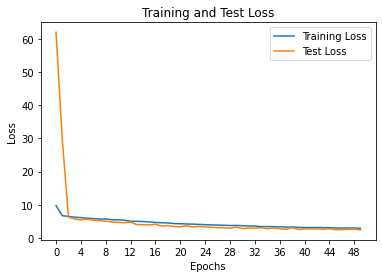

In [ ]:
# Load the training and validation loss dictionaries
train_loss = load(open('/content/drive/MyDrive/ML/train_loss_resnet.pkl', 'rb'))
test_loss = load(open('/content/drive/MyDrive/ML/test_loss_resnet.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_loss.values()
test_values = test_loss.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(50)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 50, 4))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filename =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet50_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filename)

model.save_weights(filename)

/content/drive/MyDrive/Colab Notebooks/20230306-045532resnet50_simclr.h5


#Classifier with frozen Encoder

In [ ]:
new_model = get_resnet_simclr(512, 256, 128)
new_model.load_weights("/content/drive/MyDrive/Colab Notebooks/20230306-045532resnet50_simclr.h5")

In [ ]:
classifier_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [ ]:
def Classifier_Network():
    '''For stage 2, simply a softmax on top of the Encoder.
    '''
    contrast_model = new_model
    contrast_model.trainable = False
    embedd = contrast_model.output
    features = Dropout(0.5)(embedd)
    features = Dense(64, activation="relu")(features)
    features = Dropout(0.5)(features)
    outputs  = Dense(num_classes, activation="softmax")(features)

    classifier_model = Model(contrast_model.inputs, outputs)

    return classifier_model

In [ ]:
classifier = Classifier_Network()

In [ ]:
classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [ ]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
@tf.function
# train step for the 2nd stage
def train_step(x, y,sample_weight):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_preds = classifier(x, training=True)
        loss = cce_loss_obj(y, y_preds,sample_weight = sample_weight)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss,
                              classifier.trainable_variables)
    classifier_optimizer.apply_gradients(zip(gradients,
                                  classifier.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [ ]:
@tf.function
def test_step(x, y):
    y_preds = classifier(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [ ]:
#classifier training
train_loss_dict_classifier = {}
test_loss_dict_classifier = {}
train_acc_dict = {}
test_acc_dict = {}

for epoch in range(220):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()


    for x, y in tqdm(train_ds2):
        #print(x.shape,y.shape)
        sample_weight = tf.random.uniform((tf.shape(x)[0], 1),
                                    minval=0,
                                    maxval=1,
                                    dtype=tf.float32)
        train_step(x, y,sample_weight)

    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    template = 'Epoch {}, Train Loss: {}, Train Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,train_loss.result(), train_acc.result() * 100,test_loss.result(),test_acc.result() * 100))
    train_loss_dict_classifier[epoch] = train_loss.result().numpy()
    test_loss_dict_classifier[epoch] = test_loss.result().numpy()
    train_acc_dict[epoch] = train_acc.result().numpy()*100
    test_acc_dict[epoch] = test_acc.result().numpy()*100

 10%|█         | 14/134 [00:15<02:15,  1.13s/it]


KeyboardInterrupt: ignored

In [ ]:

# Save the training loss values
with open('/content/drive/MyDrive/ML/train_loss_2_resnet.pkl', 'wb') as file:
    dump(train_loss_dict_classifier, file)

# Save the test loss values
with open('/content/drive/MyDrive/ML/test_loss_2_resnet.pkl', 'wb') as file:
    dump(test_loss_dict_classifier, file)

# Save the training acc values
with open('/content/drive/MyDrive/ML/train_acc_2_resnet.pkl', 'wb') as file:
    dump(train_acc_dict, file)

# Save the test acc values
with open('/content/drive/MyDrive/ML/test_acc_2_resnet.pkl', 'wb') as file:
    dump(test_acc_dict, file)

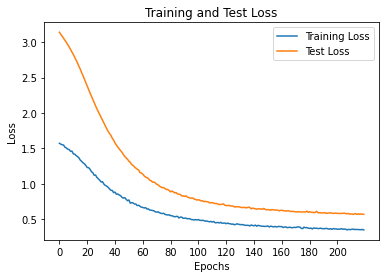

In [ ]:
# Load the training and validation loss dictionaries
train_loss_class = load(open('/content/drive/MyDrive/ML/train_loss_2_resnet.pkl', 'rb'))
test_loss_class = load(open('/content/drive/MyDrive/ML/test_loss_2_resnet.pkl', 'rb'))

# Retrieve each dictionary's values
train_values_class = train_loss_class.values()
test_values_class = test_loss_class.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values_class)).astype(float), label='Training Loss')
plt.plot(epochs, np.array(list(test_values_class)).astype(float), label='Test Loss')

# Add in a title and axes labels
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

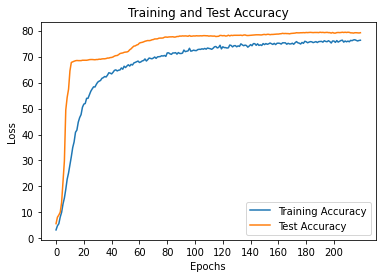

In [ ]:
# Load the training and validation loss dictionaries
train_acc = load(open('/content/drive/MyDrive/ML/train_acc_2_resnet.pkl', 'rb'))
test_acc = load(open('/content/drive/MyDrive/ML/test_acc_2_resnet.pkl', 'rb'))

# Retrieve each dictionary's values
train_values = train_acc.values()
test_values = test_acc.values()

# Generate a sequence of integers to represent the epoch numbers
epochs = range(220)

# Plot and label the training and validation loss values
plt.plot(epochs, np.array(list(train_values)).astype(float), label='Training Accuracy')
plt.plot(epochs, np.array(list(test_values)).astype(float), label='Test Accuracy')

# Add in a title and axes labels
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 220, 20))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#model save
dir = '/content/drive/MyDrive/Colab Notebooks/'
filenames =os.path.join( dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet50_accuracy_simclr.h5")  ##set your path then model name: /content/resnet.h5
print(filenames)

classifier.save_weights(filenames)

/content/drive/MyDrive/Colab Notebooks/20230321-053237resnet50_accuracy_simclr.h5


##Prediction

In [ ]:
classifier.load_weights("/content/drive/MyDrive/Colab Notebooks/20230321-053237resnet50_accuracy_simclr.h5")

In [ ]:
X = tf.reshape(x_test[50], [1, 224, 224, 3]) ##need to reshape
classifier.predict(X)

1/1 [==============================] - 2s 2s/step


array([[1.5753963e-04, 5.0676226e-05, 2.8661615e-04, 2.8193117e-05,
        6.5966495e-05, 2.2694339e-04, 1.5588134e-03, 7.8410245e-05,
        1.3044903e-03, 1.0571708e-04, 9.3708438e-04, 1.8304966e-02,
        9.5115221e-01, 2.3195948e-02, 3.9924006e-04, 5.5865961e-04,
        1.0790173e-04, 8.1630227e-05, 4.2522396e-04, 1.6459091e-04,
        1.9498161e-04, 4.3285426e-04, 1.8137472e-04]], dtype=float32)

In [ ]:
y_predict = np.argmax(classifier.predict(x_test), axis=-1)


20/67 [=======>......................] - ETA: 5:11

KeyboardInterrupt: ignored

In [ ]:
#CONFUSIN MATRIX
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

In [ ]:
class_names = ["cecum", "ileum", "retroflex_rectum", "hemorrhoids", "polyps","ulcerative_colitis_grade_0_1","ulcerative_colitis_grade_1","ulcerative_colitis_grade_1_2","ulcerative_colitis_grade_2","ulcerative_colitis_grade_2_3","ulcerative_colitis_grade_3","bbps_0_1" ,"bbps_2_3","impacted_stool","dyed_lifted_polyps","dyed_resection_margins","pylorus","retroflex_stomach","z_line","barretts","barretts_short_segment","esophagitis_a" ,"esophagitis_b_d"]
print(metrics.classification_report(y_test, y_predict, target_names=class_names))

                              precision    recall  f1-score   support

                       cecum       0.89      0.99      0.94       202
                       ileum       0.00      0.00      0.00         2
            retroflex_rectum       0.76      0.87      0.81        78
                 hemorrhoids       0.00      0.00      0.00         1
                      polyps       0.99      0.99      0.99       206
ulcerative_colitis_grade_0_1       0.00      0.00      0.00         7
  ulcerative_colitis_grade_1       0.00      0.00      0.00        40
ulcerative_colitis_grade_1_2       0.00      0.00      0.00         2
  ulcerative_colitis_grade_2       0.51      0.79      0.62        89
ulcerative_colitis_grade_2_3       0.00      0.00      0.00         5
  ulcerative_colitis_grade_3       0.00      0.00      0.00        27
                    bbps_0_1       0.90      0.95      0.92       129
                    bbps_2_3       0.93      1.00      0.96       230
              impac

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


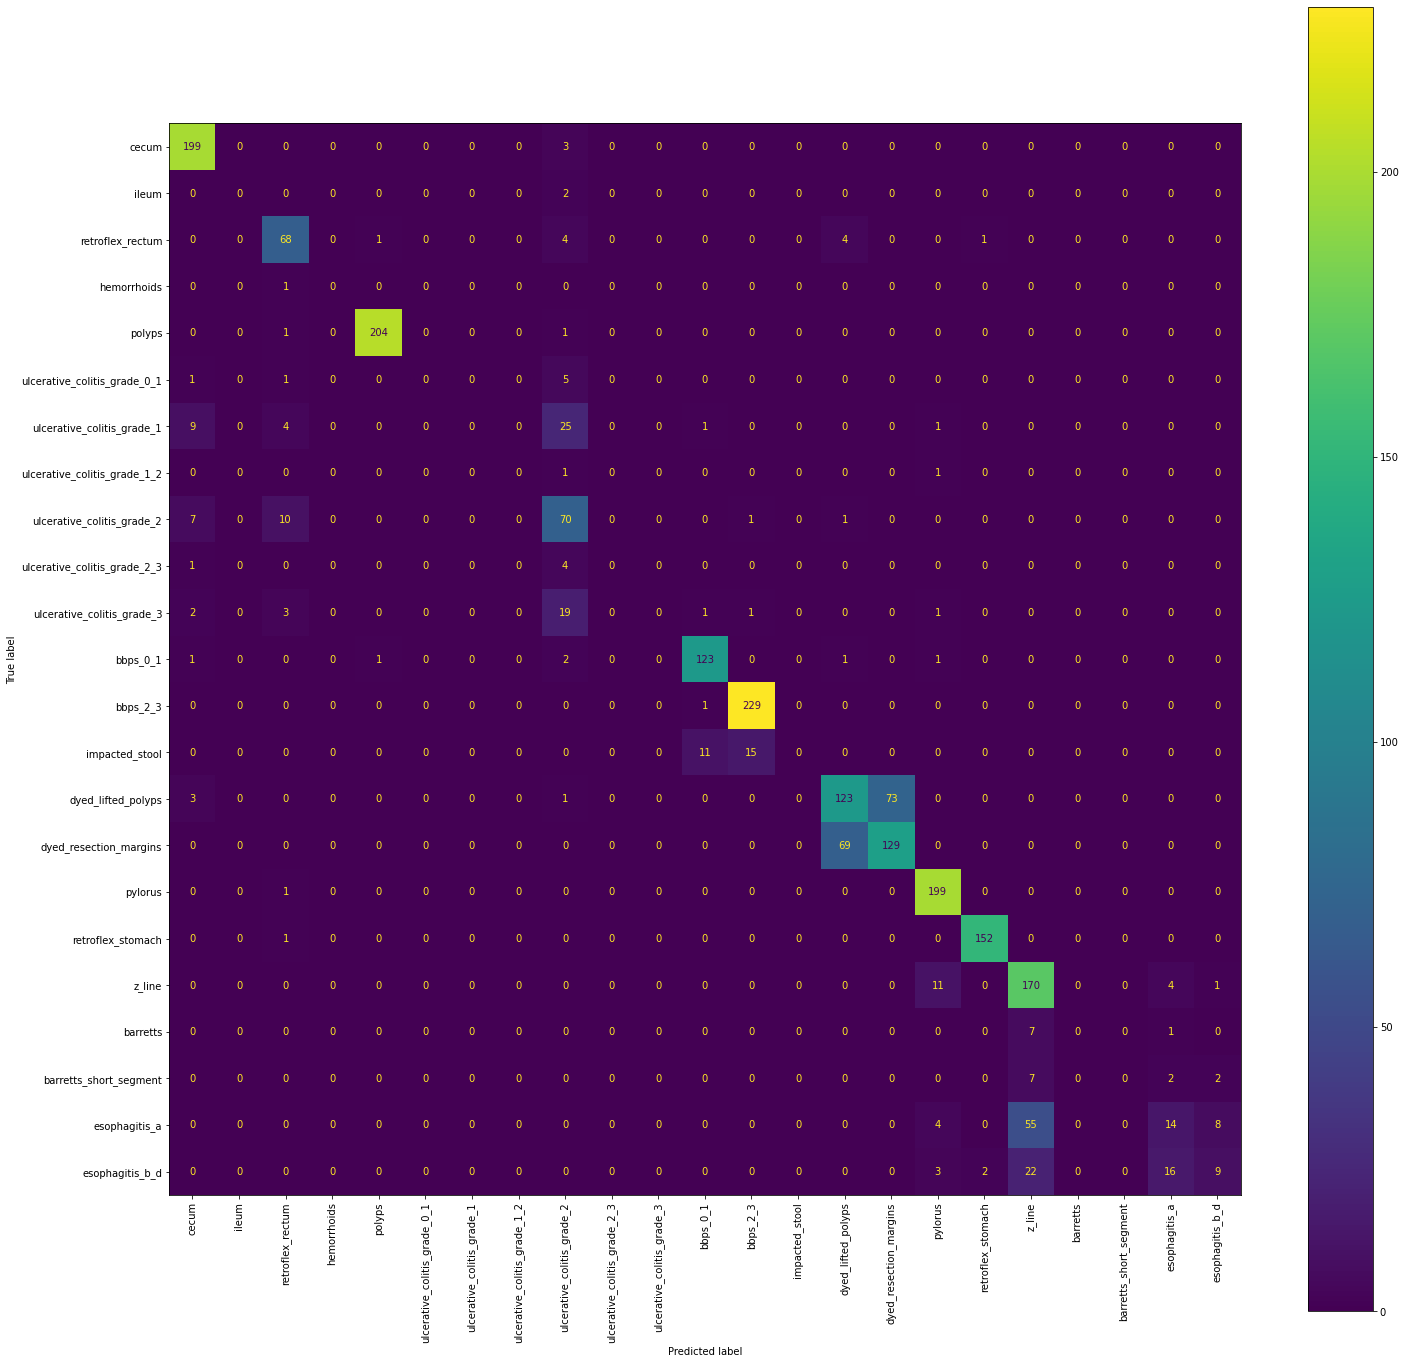

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_predict)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = class_names)

plt.rcParams["figure.figsize"] = [24,24]
cm_display.plot(xticks_rotation = 'vertical')
plt.show()

In [ ]:
#check layers trainable
for i, layer in enumerate(classifier.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

0 input_2 [(None, 224, 224, 3)] False
1 conv1_pad (None, 230, 230, 3) False
2 conv1_conv (None, 112, 112, 64) False
3 conv1_bn (None, 112, 112, 64) False
4 conv1_relu (None, 112, 112, 64) False
5 pool1_pad (None, 114, 114, 64) False
6 pool1_pool (None, 56, 56, 64) False
7 conv2_block1_1_conv (None, 56, 56, 64) False
8 conv2_block1_1_bn (None, 56, 56, 64) False
9 conv2_block1_1_relu (None, 56, 56, 64) False
10 conv2_block1_2_conv (None, 56, 56, 64) False
11 conv2_block1_2_bn (None, 56, 56, 64) False
12 conv2_block1_2_relu (None, 56, 56, 64) False
13 conv2_block1_0_conv (None, 56, 56, 256) False
14 conv2_block1_3_conv (None, 56, 56, 256) False
15 conv2_block1_0_bn (None, 56, 56, 256) False
16 conv2_block1_3_bn (None, 56, 56, 256) False
17 conv2_block1_add (None, 56, 56, 256) False
18 conv2_block1_out (None, 56, 56, 256) False
19 conv2_block2_1_conv (None, 56, 56, 64) False
20 conv2_block2_1_bn (None, 56, 56, 64) False
21 conv2_block2_1_relu (None, 56, 56, 64) False
22 conv2_block2_2_conv

#XAI

In [ ]:
##check if any error occurs here, if occurs, most likely graph not connected
def flatten_model(model):
    if not any(hasattr(layer, 'layers') for layer in model.layers):
        return model  # No sub-model defined within this model
    inputs = None
    outputs = None
    for layer in model.layers:
        if inputs is None:
            inputs = layer.input
        if hasattr(layer, 'layers'):
            submodel = layer
            last_layer = submodel.layers[-1]
            outputs = submodel.output

        if outputs is None:
            outputs = layer
        else:
            outputs = layer(outputs)
    return keras.Model(inputs=inputs, outputs=outputs)

flat_model = flatten_model(classifier)

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
X = tf.convert_to_tensor(x_test[50], dtype=tf.float32)    ##need to convert the input data to tensor
y = y_test[50].item()   ##just a single integer value, no numpy array
score = CategoricalScore(y)

In [ ]:
image_titles = ['Image']
from matplotlib import cm

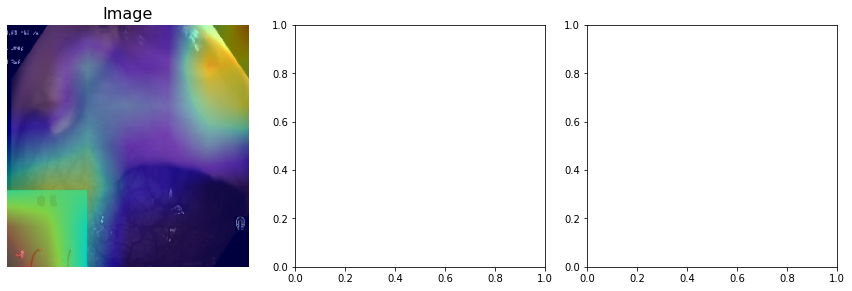

In [ ]:
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(classifier,
                  model_modifier=replace2linear,
                  clone=False)

grad_cam = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap1 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap1, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

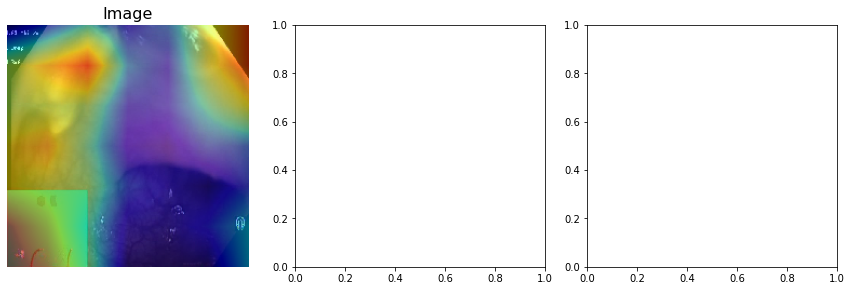

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(classifier, model_modifier=replace2linear,clone=False)

# Generate heatmap with GradCAM++
grad_cam = gradcam(score, X, penultimate_layer=-1)
# Render
#for i, title in enumerate(image_titles):
#    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap2 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap2, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with ScoreCAM
grad_cam = scorecam(score, X, penultimate_layer=-1, max_N=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap3 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap3, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

12/64 [====>.........................] - ETA: 5:37

In [ ]:
# Create ScoreCAM object
scorecam = Scorecam(classifier)

# Generate heatmap with Faster-ScoreCAM
grad_cam = scorecam(score,X,penultimate_layer=-1,max_N=10)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap4 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap4, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.layercam import Layercam

layercam = Layercam(classifier, model_modifier=replace2linear,clone = False)

# Generate heatmap with Faster-ScoreCAM
grad_cam = layercam(score,X,penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap5 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap5, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(classifier, model_modifier=replace2linear,clone=False)

# Generate saliency map
saliency_map_van = saliency(score, X)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap6 = np.uint8(cm.jet(saliency_map_van[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap6, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map_smooth = saliency(score,X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap7 = np.uint8(cm.jet(saliency_map_smooth[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap7, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from matplotlib import cm
#image_titles = ['Test']
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap8 = np.uint8(cm.jet(grad_cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(x_test[50])
    ax[i].imshow(heatmap8, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()